#El Modelo de Ising 1D
El Modelo de Ising 1D es el ejemplo más fundamental y simple de un sistema de espines que interactúan en mecánica estadística. Representa una cadena lineal de $N$ espines, donde cada espín $s_i$ solo puede tomar dos valores: "arriba" ($+1$) o "abajo" ($-1$).La característica clave es que cada espín solo interactúa con sus vecinos más cercanos.La Energía (Hamiltoniano)La energía total de una configuración (un "estado" $S = \{s_1, s_2, \dots, s_N\}$) se define por el Hamiltoniano:
$$E(S) = -J \sum_{i=1}^{N-1} s_i s_{i+1}, $$
donde $J$ (Acoplamiento) es la fuerza de interacción entre vecinos. Si $J > 0$ (ferromagnético), los espines prefieren alinearse (ej., $\uparrow\uparrow$ o $\downarrow\downarrow$). Si $J < 0$ (antiferromagnético), los espines prefieren antialinearse (ej., $\uparrow\downarrow$).

Consideramos un "anillo" (con condiciones de borde periódicas), por lo tanto en $\sum_{i=1}^{N} s_i s_{i+1}$, tomamos la ultima pareja asi $s_{N+1} = s_1$.


Temperatura T = 0.5
Magnetización promedio por espín = -0.051


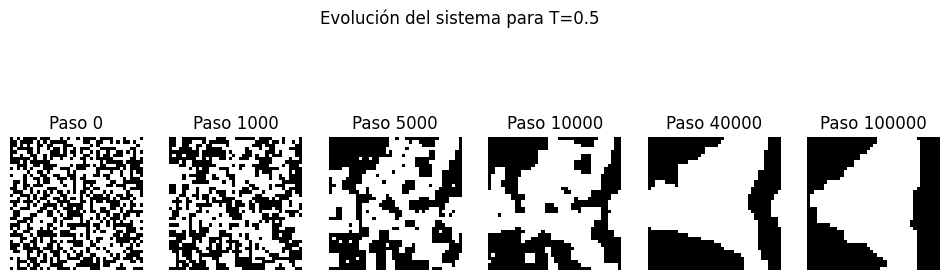

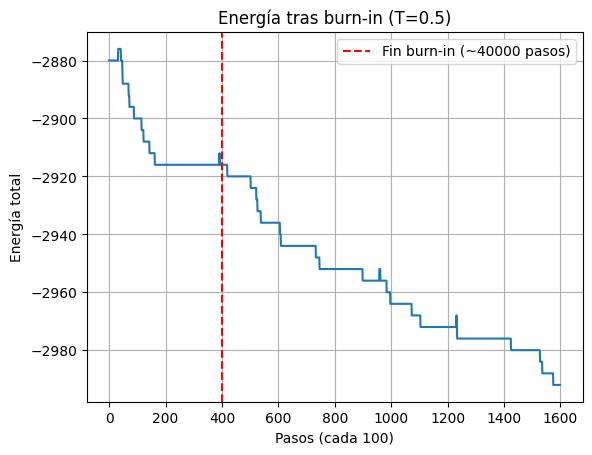


Temperatura T = 3.0
Magnetización promedio por espín = 0.006


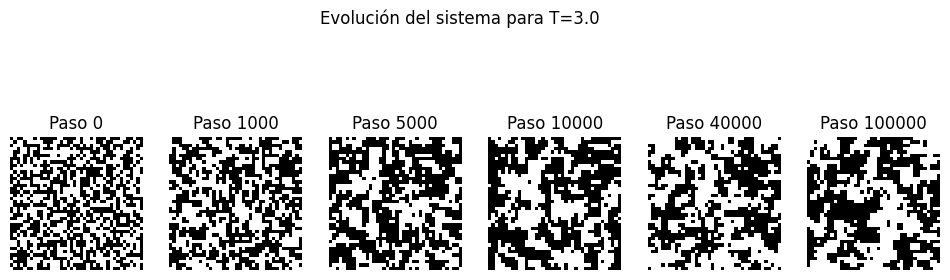

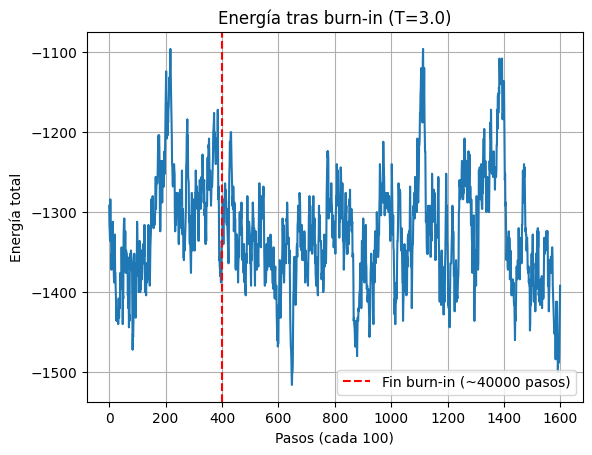

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------
# PARÁMETROS DEL MODELO
# ---------------------------------------
N = 40          # Tamaño de la red
J = 1.0         # Interacción ferromagnética
pasos = 200000  # Total de iteraciones
burn_in = pasos // 5   # 20% de burn-in


# ---------------------------------------
# FUNCIÓN DE ENERGÍA (CORRECTA)
# ---------------------------------------
def energia_total(espines):
    energia = 0.0
    for i in range(N):
        for j in range(N):
            s = espines[i, j]
            vecinos = (
                espines[(i+1)%N, j] +
                espines[(i-1)%N, j] +
                espines[i, (j+1)%N] +
                espines[i, (j-1)%N]
            )
            energia -= J * s * vecinos
    return energia / 2  # Evitar doble conteo


# ---------------------------------------
# METROPOLIS-HASTINGS
# ---------------------------------------
def simular(T):

    beta = 1.0 / T
    espines = np.random.choice([-1, 1], (N, N))

    energia_actual = energia_total(espines)

    energias = []
    magnetizaciones = []
    snapshots = {}

    momentos = [0, 1000, 5000, 10000, 40000, 100000]

    #(...)
    for paso in range(pasos+1):

        # Elegir un espín aleatoriamente
        i = np.random.randint(0, N)
        j = np.random.randint(0, N)

        s_ij = espines[i, j]
        vecinos = (
            espines[(i+1)%N, j] +
            espines[(i-1)%N, j] +
            espines[i, (j+1)%N] +
            espines[i, (j-1)%N]
        )

        delta_E = 2 * J * s_ij * vecinos

        # Metropolis
        if delta_E < 0 or np.random.random() < np.exp(-beta * delta_E):
            espines[i, j] *= -1
            energia_actual += delta_E
    #(...)


        # Guardar snapshots
        if paso in momentos:
            snapshots[paso] = espines.copy()

        # Guardar datos SOLO después del burn-in
        if paso > burn_in and paso % 100 == 0:
            energias.append(energia_actual)
            magnetizaciones.append(np.sum(espines))

    return espines, energias, magnetizaciones, snapshots


# ---------------------------------------
# VISUALIZACIÓN POR TEMPERATURA
# ---------------------------------------
def resultados(T):
    esp, energias, mags, snaps = simular(T)

    print(f"\nTemperatura T = {T}")
    print(f"Magnetización promedio por espín = {np.mean(mags)/(N*N):.3f}")

    # Snapshots
    fig, ax = plt.subplots(1, len(snaps), figsize=(12, 4))
    for k, paso in enumerate(sorted(snaps.keys())):
        ax[k].imshow(snaps[paso], cmap='binary')
        ax[k].set_title(f"Paso {paso}")
        ax[k].axis("off")
    plt.suptitle(f"Evolución del sistema para T={T}")
    plt.show()

    # Energía en equilibrio
    plt.plot(energias)
    plt.axvline(x=burn_in//100, color='r', linestyle='--',
                label=f'Fin burn-in (~{burn_in} pasos)')
    plt.xlabel("Pasos (cada 100)")
    plt.ylabel("Energía total")
    plt.title(f"Energía tras burn-in (T={T})")
    plt.legend()
    plt.grid(True)
    plt.show()


# ---------------------------------------
# EJECUCIÓN: TRANSICIÓN DE FASE
# ---------------------------------------
resultados(T=0.5)   # T baja → orden
resultados(T=3.0)   # T alta → desorden


#**Integración ecuación PN RK4**


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# ==========================================================
# PARÁMETROS
# ==========================================================

M = 1.0
nu = 0.25

t_junk = 392
t_isco = 3410.87937023578

# Frecuencia angular en t_junk (dato que me diste)
omega_junk = 0.034892958160916906

# Pasar a frecuencia orbital
F_junk = omega_junk / (2*np.pi)

# v inicial que asegura obtener la solución única para el problema a evaluar.
v0 = (np.pi * M * F_junk)**(1/3)

# ==========================================================
# ECUACIÓN TAYLOR T4 (dv/dt)
# ==========================================================

def dvdt(t, v, M, nu):


    pref = (32/5) * (nu / M) * v**9

    pn2 = (743/336) + (11/4)*nu
    pn3 = 4*np.pi
    pn4 = (34103/18144) + (13661/2016)*nu + (59/18)*nu**2
    pn5 = (4159/672) + (189/8)*nu

    pn6a = (16447322263/139708800) + (16/3)*np.pi**2 - (1712/105)*np.euler_gamma
    pn6b = nu * ((451/48)*np.pi**2 - (56198689/217728))
    pn6c = (541/896)*nu - (5605/2592)*nu**2
    pn6d = -(856/105)*np.log(16 * v**2)

    pn6 = pn6a + pn6b + pn6c + pn6d

    pn7 = (4415/4032) - (358675/6048)*nu - (91495/1512)*nu**2

    PN = (1
          - pn2*v**2
          + pn3*v**3
          + pn4*v**4
          - pn5*np.pi*v**5
          + pn6*v**6
          - pn7*np.pi*v**7)

    return pref * PN




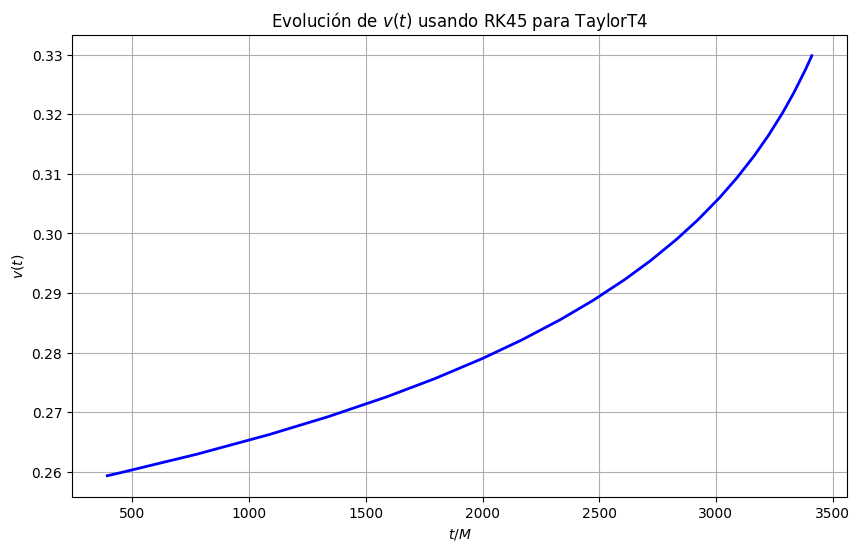

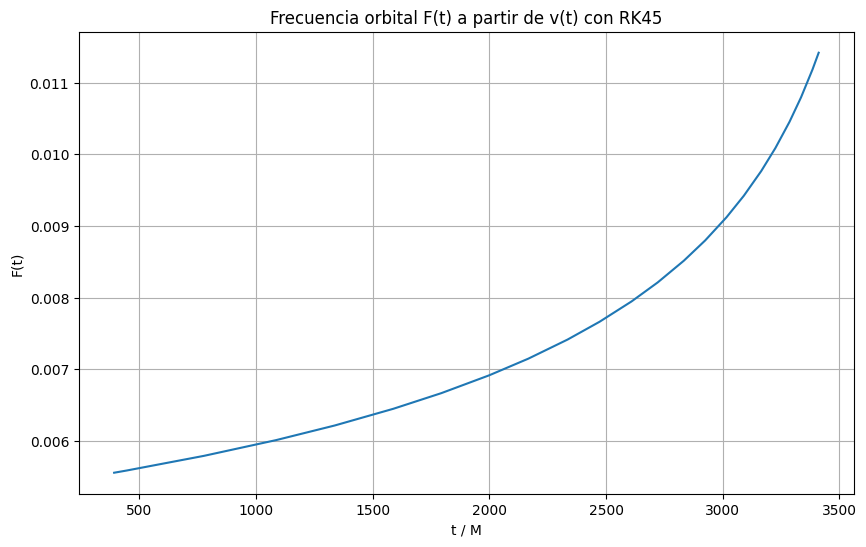

In [ ]:
#@title Integración usando RK45 Dormand-Prince

#se aclara que se usa el método especifico ya que la librería se scipy trae los dso métodos cargados
sol_r = solve_ivp(
    dvdt,
    [t_junk, t_isco],
    [v0],
    args=(M, nu),
    rtol=1e-9,
    atol=1e-12,
    method='RK45',
)

#Solve_ivp no necesita de paso constante ya que el código se adpata para llegar a la precisión especificada en rtol por lo que no necesita un arreglo de tiempo con paso cte.
#Tiempos junto al valor de velocidad orbital para cada punto dentro de t_junk y t_isco, obtenidos con RK45
t_r = sol_r.t
v_r = sol_r.y[0]

plt.figure(figsize=(10,6))
plt.plot(t_r, v_r, color="blue", lw=2)
plt.xlabel(r"$t / M$")
plt.ylabel(r"$v(t)$")
plt.title(r"Evolución de $v(t)$ usando RK45 para TaylorT4")
plt.grid()
plt.show()

# Valor de F calculado a partir de v como: F = v^3 / (pi * M)
F_r = (v_r)**3 / (np.pi * M)

plt.figure(figsize=(10,6))
plt.plot(t_r, F_r)
plt.xlabel("t / M")
plt.ylabel("F(t)")
plt.title("Frecuencia orbital F(t) a partir de v(t) con RK45")
plt.grid()
plt.show()

In [ ]:
t_r

array([ 392.        ,  392.04944059,  392.54384654,  397.48790597,
        446.9285003 ,  776.76430727, 1086.40536617, 1337.35582731,
       1588.30628845, 1793.65798575, 1999.00968306, 2166.92037354,
       2334.83106402, 2472.02034965, 2609.20963528, 2721.20509921,
       2833.20056314, 2924.54787838, 3015.89519363, 3090.33126593,
       3164.76733824, 3225.36299784, 3285.95865744, 3335.23625079,
       3384.51384414, 3410.87937024])

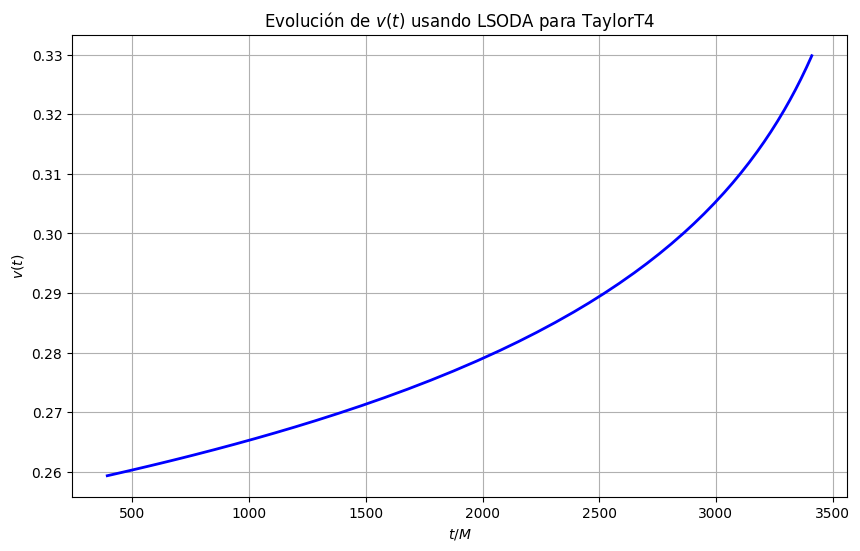

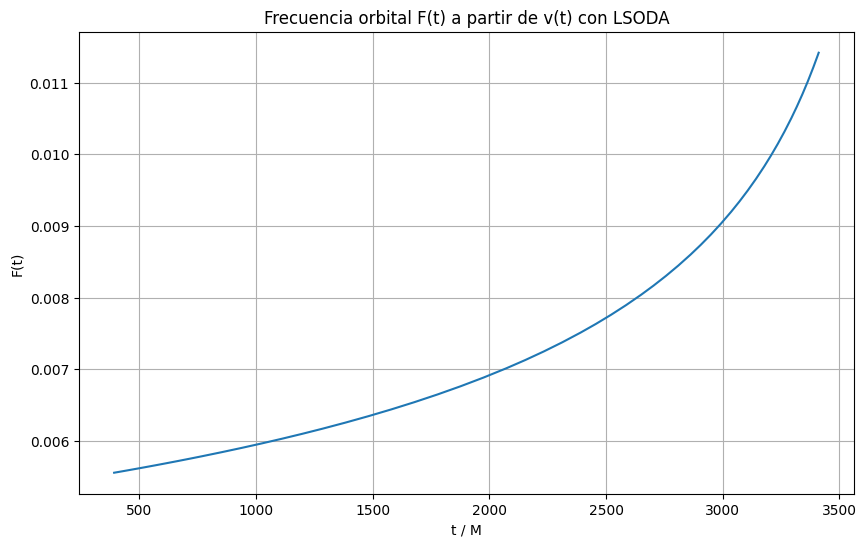

In [ ]:
#@title Integración usando LSODA

#se aclara que se usa el método especifico ya que la librería se scipy trae los dso métodos cargados
sol_l = solve_ivp(
    dvdt,
    [t_junk, t_isco],
    [v0],
    args=(M, nu),
    rtol=1e-9,
    atol=1e-12,
    method='LSODA',
)

#Solve_ivp no necesita de paso constante ya que el código se adpata para llegar a la precisión especificada en rtol por lo que no necesita un arreglo de tiempo con paso cte.
#Tiempos junto al valor de velocidad orbital para cada punto dentro de t_junk y t_isco
t_l = sol_l.t
v_l = sol_l.y[0]

plt.figure(figsize=(10,6))
plt.plot(t_l, v_l, color="blue", lw=2)
plt.xlabel(r"$t / M$")
plt.ylabel(r"$v(t)$")
plt.title(r"Evolución de $v(t)$ usando LSODA para TaylorT4")
plt.grid()
plt.show()

# Compute F from v: F = v^3 / (pi * M)
F_l = v_l**3 / (np.pi * M)

plt.figure(figsize=(10,6))
plt.plot(t_l, F_l)
plt.xlabel("t / M")
plt.ylabel("F(t)")
plt.title("Frecuencia orbital F(t) a partir de v(t) con LSODA")
plt.grid()
plt.show()

In [ ]:
t_array = np.linspace(t_junk, t_isco, 30)

def rk4_v(v0, t_array, M, nu):
    """
    Integra dv/dt = dvdt(t, v, M, nu) usando RK4 clásico
    sobre los tiempos dados en t_array.
    """
    N = len(t_array)
    v_sol = np.zeros(N)
    v_sol[0] = v0

    for i in range(N - 1):
        t_n = t_array[i]
        h   = t_array[i+1] - t_array[i]   # paso de tiempo
        v_n = v_sol[i]

        k1 = dvdt(t_n,           v_n,               M, nu)
        k2 = dvdt(t_n + h/2,   v_n + h*k1/2,    M, nu)
        k3 = dvdt(t_n + h/2,   v_n + h*k2/2,    M, nu)
        k4 = dvdt(t_n + h,       v_n + h*k3,        M, nu)

        v_sol[i+1] = v_n + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

    return v_sol

v_array = rk4_v(v0, t_array, M, nu)


[0.25935976 0.26029274 0.26125808 0.26225798 0.26329489 0.26437153
 0.26549092 0.26665641 0.2678718  0.26914134 0.27046984 0.27186279
 0.27332644 0.27486803 0.2764959  0.27821983 0.28005131 0.282004
 0.28409432 0.28634218 0.28877211 0.29141475 0.29430911 0.2975058
 0.3010722  0.30510073 0.30972286 0.3151347  0.32164734 0.32979833]


v0 = 0.2593597614233551


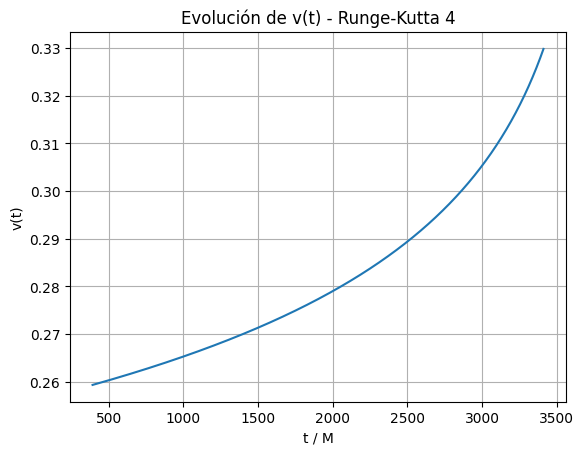

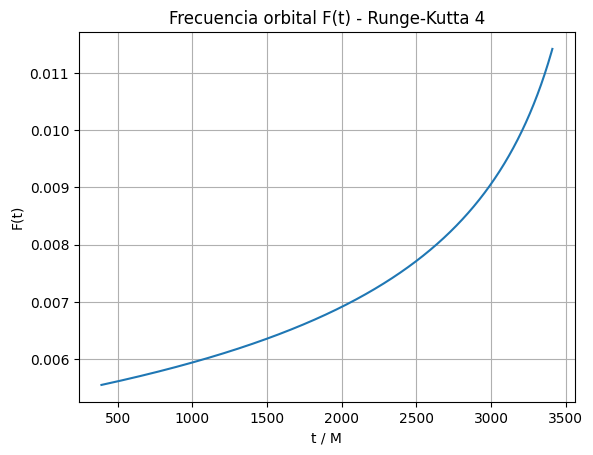

In [ ]:


# Mallado temporal (aquí puedes cambiar el número de puntos)
N = 50000
t_array = np.linspace(t_junk, t_isco, N)


# ==========================================================
# ECUACIÓN TAYLOR T4 (dv/dt)
# ==========================================================

def dvdt(t, v, M, nu):

    v = v[0]

    pref = (32/5) * (nu / M) * v**9

    pn2 = (743/336) + (11/4)*nu
    pn3 = 4*np.pi
    pn4 = (34103/18144) + (13661/2016)*nu + (59/18)*nu**2
    pn5 = (4159/672) + (189/8)*nu

    pn6a = (16447322263/139708800) + (16/3)*np.pi**2 - (1712/105)*np.euler_gamma
    pn6b = nu * ((451/48)*np.pi**2 - (56198689/217728))
    pn6c = (541/896)*nu - (5605/2592)*nu**2
    pn6d = -(856/105)*np.log(16 * v**2)

    pn6 = pn6a + pn6b + pn6c + pn6d

    pn7 = (4415/4032) - (358675/6048)*nu - (91495/1512)*nu**2

    PN = (1
          - pn2*v**2
          + pn3*v**3
          + pn4*v**4
          - pn5*np.pi*v**5
          + pn6*v**6
          - pn7*np.pi*v**7)

    return [pref * PN]


# ==========================================================
# RUNGE-KUTTA 4 CLÁSICO
# ==========================================================

def rk4_v(v0, t_array, M, nu):

    N = len(t_array)
    v_sol = np.zeros(N)
    v_sol[0] = v0

    for i in range(N - 1):
        t_n = t_array[i]
        h   = t_array[i+1] - t_array[i]
        v_n = v_sol[i]

        k1 = dvdt(t_n,           [v_n],               M, nu)[0]
        k2 = dvdt(t_n + h/2,   [v_n + h*k1/2],    M, nu)[0]
        k3 = dvdt(t_n + h/2,   [v_n + h*k2/2],    M, nu)[0]
        k4 = dvdt(t_n + h,     [v_n + h*k3],      M, nu)[0]

        v_sol[i+1] = v_n + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

    return v_sol


# ==========================================================
# INTEGRACIÓN
# ==========================================================

v_array = rk4_v(v0, t_array, M, nu)

# Frecuencia orbital F(t)
F_array = v_array**3 / (np.pi * M)


# ==========================================================
# GRÁFICA DE v(t)
# ==========================================================

plt.figure()
plt.plot(t_array, v_array)
plt.xlabel("t / M")
plt.ylabel("v(t)")
plt.title("Evolución de v(t) - Runge-Kutta 4")
plt.grid()
plt.show()


# ==========================================================
# GRÁFICA DE F(t)
# ==========================================================

plt.figure()
plt.plot(t_array, F_array)
plt.xlabel("t / M")
plt.ylabel("F(t)")
plt.title("Frecuencia orbital F(t) - Runge-Kutta 4")
plt.grid()
plt.show()
